# Wave Order Recognition - Jupyter Notebook

In [1]:
import torch
from torch import nn
import os
import json
# import nbimporter  # use this to import from Jupyter notebooks
from datetime import datetime
import random
import numpy as np
import tqdm.notebook as tqdm
import snntorch as snn
import torch.nn.functional as F
from plot_functions import *
from dataset_generation import *
from training_validation_testing import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# Create "simulations" folder three levels up from the current directory, if it doesn't exist already
parent_folder = os.path.dirname(os.getcwd())  # Get the parent directory (1st level up)
grandparent_folder = os.path.dirname(parent_folder) # Go up another level (2nd level up)
grangrandparent_folder = os.path.dirname(grandparent_folder) # Go up another level (3rd level up)
simulations_folder = os.path.join(grangrandparent_folder, 'Wave_Order_Recognition_simulations')
os.makedirs(simulations_folder, exist_ok=True)

# Create unique folder name inside the "simulations" folder
now = datetime.now()
unique_folder_name = os.path.join(simulations_folder, now.strftime("JYPNB_wave_order_recognition_%Yy%mm%dd_%Hh%Mm"))
os.makedirs(unique_folder_name, exist_ok=True)

# Seeds for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)

Device: cpu


## Hyperparameters

In [2]:
"""

                    HYPERPARAMETERS

"""

std_dev = 0.0
num_samples = 1000
train_ratio = 0.7
test_ratio = 0.1
validation_ratio = 0.2

freq_min = 2
freq_max = 2
amp_min = 1.1
amp_max = 1.1
offset = 1.1

sample_rate = 40 * freq_max
duration = 3
deltaT = 1 / sample_rate
num_steps = int(duration / deltaT)

input_size = 1
hidden_size = 8
output_size = 2

threshold_hidden_min = 1.8
threshold_hidden_max = 1.9
learn_threshold_hidden = False

threshold_output_min = 2.4
threshold_output_max = 2.6
learn_threshold_output = False

N_hidden_weights_gaussian = 30
N_output_weights_gaussian= 200

N_hidden_weights_std = np.sqrt(N_hidden_weights_gaussian)
N_output_weights_std = np.sqrt(N_output_weights_gaussian)

gaussian_mean_hidden_weights = N_hidden_weights_gaussian / sample_rate
gaussian_std_hidden_weights = N_hidden_weights_std / sample_rate

gaussian_mean_output_weights = N_output_weights_gaussian / (sample_rate * hidden_size)
gaussian_std_output_weights = N_output_weights_std / (sample_rate * hidden_size)

hidden_reset_mechanism = 'zero'
output_reset_mechanism = 'zero'

weights_hidden_min_clamped = 0.0
weights_hidden_max_clamped = 2.0
weights_output_min_clamped = 0.0
weights_output_max_clamped = 2.0

N_hidden_tau, N_output_tau = 0.1, 00.1
tau_hidden = torch.Tensor(hidden_size).uniform_(N_hidden_tau * freq_min, 100 * N_hidden_tau * freq_max)
tau_output = torch.Tensor(output_size).uniform_(N_output_tau * freq_min, 10 * N_output_tau * freq_max)

beta_hidden = torch.exp(-deltaT / tau_hidden)
beta_output = torch.exp(-deltaT / tau_output)

learn_beta_hidden = True
learn_beta_output = True

threshold_hidden = np.random.uniform(threshold_hidden_min, threshold_hidden_max, hidden_size)
threshold_output = np.random.uniform(threshold_output_min, threshold_output_max, output_size)

# Training parameters
num_epochs = 200
learning_rate = 0.05
batch_size = 32                     # 32 is Yann LeCun's magic number
optimizer_betas = (0.99, 0.999)     # Adam optimizer's betas, first value is for the gradient and the second for the gradient squared
scheduler_step_size = 50            # Decrease the learning rate by scheduler_gamma every scheduler_step_size epochs
scheduler_gamma = 0.4
penalty_weight = 0.001              # Weight of the spike_count regularization term
L1_lambda = 0.001                   # L1 regularization strength

# Save hyperparameters
hyperparams = {
    "seed": seed,
    "std_dev": std_dev,
    "offset": offset,
    "num_samples": num_samples,
    "train_ratio": train_ratio,
    "test_ratio": test_ratio,
    "validation_ratio": validation_ratio,
    "freq_min": freq_min,
    "freq_max": freq_max,
    "amp_min": amp_min,
    "amp_max": amp_max,
    "sample_rate": sample_rate,
    "duration": duration,
    "deltaT": deltaT,
    "input_size": input_size,
    "hidden_size": hidden_size,
    "output_size": output_size,
    "num_steps": num_steps,
    "threshold_hidden_min": threshold_hidden_min,
    "threshold_hidden_max": threshold_hidden_max,
    "threshold_output_min": threshold_output_min,
    "threshold_output_max": threshold_output_max,
    "gaussian_mean_hidden_weights": gaussian_mean_hidden_weights,
    "gaussian_std_hidden_weights": gaussian_std_hidden_weights,
    "gaussian_mean_output_weights": gaussian_mean_output_weights,
    "gaussian_std_output_weights": gaussian_std_output_weights,
    "hidden_reset_mechanism": hidden_reset_mechanism,
    "output_reset_mechanism": output_reset_mechanism,
    "weights_hidden_min_clamped": weights_hidden_min_clamped,
    "weights_hidden_max_clamped": weights_hidden_max_clamped,
    "weights_output_min_clamped": weights_output_min_clamped,
    "weights_output_max_clamped": weights_output_max_clamped,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "optimizer_betas": optimizer_betas,
    "scheduler_step_size": scheduler_step_size,
    "scheduler_gamma": scheduler_gamma,
    "beta_hidden": beta_hidden.tolist(),
    "beta_output": beta_output.tolist(),
    "threshold_hidden": threshold_hidden.tolist(),
    "threshold_output": threshold_output.tolist(),
    "N_hidden_weights_gaussian": N_hidden_weights_gaussian,
    "N_hidden_weights_std": N_hidden_weights_std,
    "N_output_weights_gaussian": N_output_weights_gaussian,
    "N_output_weights_std": N_output_weights_std,
    "learn_beta_hidden": learn_beta_hidden,
    "learn_beta_output": learn_beta_output,
    "learn_threshold_hidden": learn_threshold_hidden,
    "learn_threshold_output": learn_threshold_output,
    "hidden_tau": N_hidden_tau,
    "output_tau": N_output_tau,
    "penalty_weight": penalty_weight,
    "L1_lambda": L1_lambda
}

with open(os.path.join(unique_folder_name, 'hyperparameters.json'), 'w') as f:
    json.dump(hyperparams, f)

## Spiking Neural Network

In [3]:
# Define the Spiking Neural Network
class Wave_Order_Recognition_SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False)
        self.lif1 = snn.Leaky(beta=beta_hidden, threshold=threshold_hidden, learn_beta=learn_beta_hidden, learn_threshold=learn_threshold_hidden, reset_mechanism=hidden_reset_mechanism, reset_delay=False)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=False)
        self.lif2 = snn.Leaky(beta=beta_output, threshold=threshold_output, learn_beta=learn_beta_output, learn_threshold=learn_threshold_output, reset_mechanism=output_reset_mechanism, reset_delay=False)

        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.normal_(self.fc1.weight, mean=gaussian_mean_hidden_weights, std=gaussian_std_hidden_weights)
        nn.init.normal_(self.fc2.weight, mean=gaussian_mean_output_weights, std=gaussian_std_output_weights)

    def forward(self, x, mem1=None, mem2=None):
        batch_size = x.size(0)
        if mem1 is None:
            mem1 = torch.zeros(batch_size, self.fc1.out_features, device=x.device)
        if mem2 is None:
            mem2 = torch.zeros(batch_size, self.fc2.out_features, device=x.device)

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []
        hidden_spike_count = 0
        output_spike_count = 0

        for step in range(num_steps):
            cur1 = self.fc1(x[:, step].unsqueeze(1))  # Process one time step at a time
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

            hidden_spike_count += spk1.sum().item()
            output_spike_count += spk2.sum().item()

            scheduler.step()

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), hidden_spike_count, output_spike_count


In [4]:
dataset = Wave_Order_Dataset(num_samples, sample_rate, duration, freq_min, freq_max, amp_min, amp_max, std_dev, offset)         # Initialize the dataset
train_dataset, validation_dataset, test_dataset = split_dataset(dataset, train_ratio, validation_ratio, test_ratio)             # Split the dataset
train_loader, validation_loader, test_loader = get_dataloaders(train_dataset, validation_dataset, test_dataset, batch_size)     # Get dataloaders

model = Wave_Order_Recognition_SNN(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, betas=optimizer_betas)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

validation_accuracies = []
test_accuracies = []
loss_hist = []
test_loss_hist = []
beta1_values = []
beta2_values = []
weights_hidden_layer = []
weights_output_layer = []
threshold_hidden_layer = []
threshold_output_layer = []
hidden_spike_count = []
output_spike_count = []
output_spike_counts_neuron0 = []
output_spike_counts_neuron1 = []
equal_prediction_values = []
pbar = tqdm.trange(num_epochs, desc='Epochs')

for epoch in pbar:
    loss, avg_hidden_spike_count, avg_output_spike_count, avg_output_spike_counts_neuron0, avg_output_spike_counts_neuron1 = train_model(model, train_loader, criterion, optimizer, epoch, num_epochs, batch_size, hidden_size, output_size, weights_hidden_min_clamped, weights_hidden_max_clamped, weights_output_min_clamped, weights_output_max_clamped, penalty_weight, L1_lambda, device)

    validation_accuracy, validation_loss = validate_model(model, validation_loader, criterion, device)
    test_metrics = test_model(model, test_loader, criterion, device)
    test_accuracy = test_metrics['Accuracy']
    equal_prediction = test_metrics['Equal Prediction']
    total_predictions = test_metrics['Total Predictions']
    validation_accuracies.append(validation_accuracy)
    test_accuracies.append(test_accuracy)
    equal_prediction_values.append(equal_prediction)
    beta1_values.append(model.lif1.beta.detach().cpu().numpy().flatten())
    beta2_values.append(model.lif2.beta.detach().cpu().numpy().flatten())
    threshold_hidden_layer.append(model.lif1.threshold.detach().cpu().numpy().flatten())
    threshold_output_layer.append(model.lif2.threshold.detach().cpu().numpy().flatten())
    weights_hidden_layer.append(model.fc1.weight.detach().cpu().numpy().copy())
    weights_output_layer.append(model.fc2.weight.detach().cpu().numpy().copy())
    hidden_spike_count.append(avg_hidden_spike_count)
    output_spike_count.append(avg_output_spike_count)
    output_spike_counts_neuron0.append(avg_output_spike_counts_neuron0)
    output_spike_counts_neuron1.append(avg_output_spike_counts_neuron1)
    loss_hist.append(loss)
    test_loss_hist.append(validation_loss)
    validate_model(model, validation_loader, criterion, device)
    scheduler.step()

    equal_pred_ratio = equal_prediction / total_predictions * 100
    equal_pred_str = f'{equal_prediction}/{total_predictions} ({equal_pred_ratio:.2f}%)'

    if epoch == 0 or epoch == num_epochs - 1:
        print(f'Epoch [{epoch + 1}/{num_epochs}]  ||  Test Accuracy: {test_accuracy:.2f}%  ||  Validation Accuracy: {validation_accuracy:.2f}%  ||  Loss: {loss:.4f}  ||  Validation Loss: {validation_loss:.4f}  ||  Equal Prediction (test): {equal_pred_str}')
    elif epoch % 5 == 0:
        print(f'Epoch [{epoch}/{num_epochs}]  ||  Test Accuracy: {test_accuracy:.2f}%  ||  Validation Accuracy: {validation_accuracy:.2f}%  ||  Loss: {loss:.4f}  ||  Validation Loss: {validation_loss:.4f}  ||  Equal Prediction (test): {equal_pred_str}')
    pbar.set_postfix({'Test Accuracy': test_accuracy, 'Validation Accuracy': validation_accuracy, 'Loss': loss})


torch.save(model.state_dict(), os.path.join(unique_folder_name, 'model.pth'))

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200]  ||  Test Accuracy: 40.82%  ||  Validation Accuracy: 60.82%  ||  Loss: 1.9641  ||  Validation Loss: 0.9342  ||  Equal Prediction (test): 0/49 (0.00%)
Epoch [5/200]  ||  Test Accuracy: 42.86%  ||  Validation Accuracy: 60.82%  ||  Loss: 0.7676  ||  Validation Loss: 0.6931  ||  Equal Prediction (test): 49/49 (100.00%)
Epoch [10/200]  ||  Test Accuracy: 67.35%  ||  Validation Accuracy: 60.82%  ||  Loss: 0.7672  ||  Validation Loss: 0.6931  ||  Equal Prediction (test): 49/49 (100.00%)
Epoch [15/200]  ||  Test Accuracy: 42.86%  ||  Validation Accuracy: 60.82%  ||  Loss: 0.7669  ||  Validation Loss: 0.6931  ||  Equal Prediction (test): 49/49 (100.00%)
Epoch [20/200]  ||  Test Accuracy: 48.98%  ||  Validation Accuracy: 60.82%  ||  Loss: 0.7668  ||  Validation Loss: 0.6931  ||  Equal Prediction (test): 49/49 (100.00%)
Epoch [25/200]  ||  Test Accuracy: 44.90%  ||  Validation Accuracy: 60.82%  ||  Loss: 0.7668  ||  Validation Loss: 0.6931  ||  Equal Prediction (test): 49/49 (100.00

# Plots

## Accuracy

### Training and Validation Accuracy

In [5]:
plot_accuracies(num_epochs, test_accuracies, validation_accuracies, os.path.join(unique_folder_name, 'accuracy_plot'))

### Training and Validation Loss

In [6]:
plot_loss_curve(loss_hist, test_loss_hist, num_epochs, os.path.join(unique_folder_name, 'loss_curve'))

### Confusion Matrix

In [7]:
plot_metrics(test_metrics,os.path.join(unique_folder_name, 'evaluation_plots'))

Test Loss: 0.6931
Accuracy = (TP + TN) \ (TP + TN + FP + FN) = 48.98%
Precision = TP \ (TP + FP) = 0.51
Recall = TP \ (TP + FN) = 0.49
F1 Score = 2 * (Precision * Recall) \ (Precision + Recall) = 0.49
Equal Predictions: 49 (100.00%)


### Equal Prediction Count

In [8]:
plot_equal_prediction_values(equal_prediction_values, num_epochs, os.path.join(unique_folder_name, 'equal_prediction_values'))

## SNN Values

### Beta Values

In [9]:
plot_beta_values(beta1_values, num_epochs, os.path.join(unique_folder_name, 'beta_hidden_layer'), layer_name='Hidden')

In [10]:
plot_beta_values(beta2_values, num_epochs, os.path.join(unique_folder_name, 'beta_output_layer'), layer_name='Output')

### Tau Values

In [11]:
plot_tau_values(beta1_values, num_epochs, deltaT, os.path.join(unique_folder_name, 'tau_hidden_layer'), layer_name='Hidden')

In [12]:
plot_tau_values(beta2_values, num_epochs, deltaT, os.path.join(unique_folder_name, 'tau_output_layer'), layer_name='Output')

### Weights

In [13]:
plot_layer_weights(weights_hidden_layer, num_epochs, os.path.join(unique_folder_name, 'weights_hidden_layer'), 'Hidden')

In [14]:
plot_layer_weights(weights_output_layer, num_epochs, os.path.join(unique_folder_name, 'weights_output_layer'), 'Output')

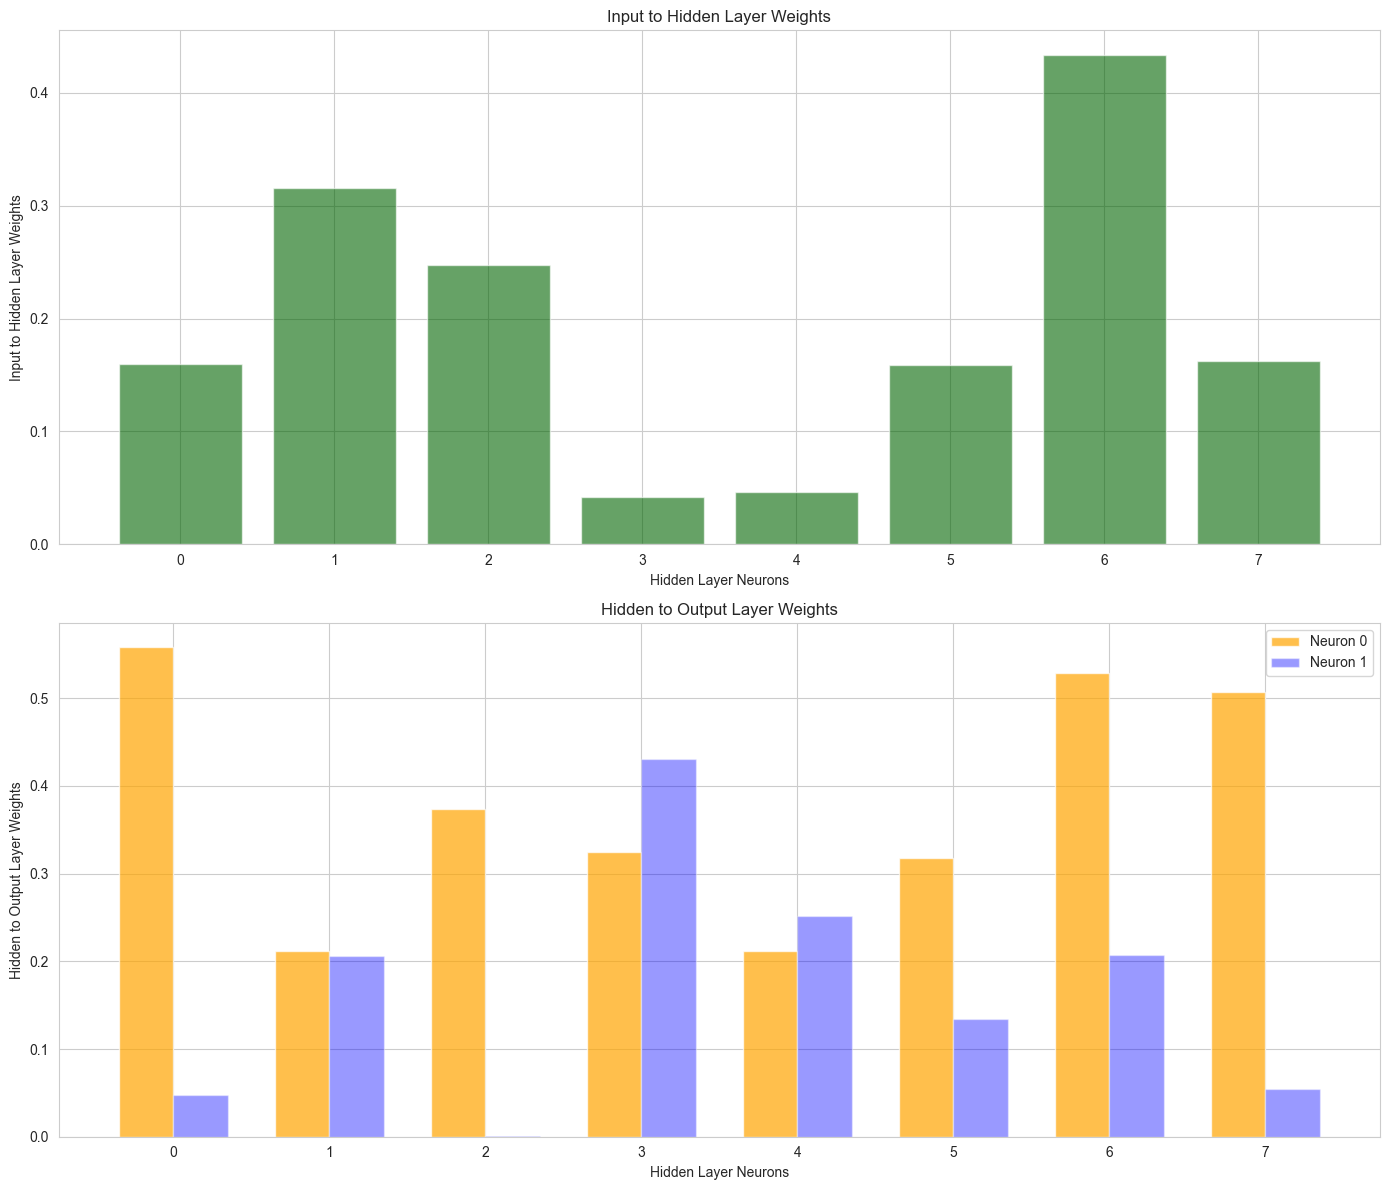

Weights from hidden to output neuron 0:
Hidden Neuron 0: 0.558
Hidden Neuron 1: 0.212
Hidden Neuron 2: 0.374
Hidden Neuron 3: 0.324
Hidden Neuron 4: 0.211
Hidden Neuron 5: 0.318
Hidden Neuron 6: 0.529
Hidden Neuron 7: 0.507

Weights from hidden to output neuron 1:
Hidden Neuron 0: 0.048
Hidden Neuron 1: 0.206
Hidden Neuron 2: 0.001
Hidden Neuron 3: 0.430
Hidden Neuron 4: 0.251
Hidden Neuron 5: 0.135
Hidden Neuron 6: 0.208
Hidden Neuron 7: 0.055


In [15]:
plot_weights_comparison(weights_hidden_layer, weights_output_layer, unique_folder_name)

## Spike and Membrane Values

### Spike Counts

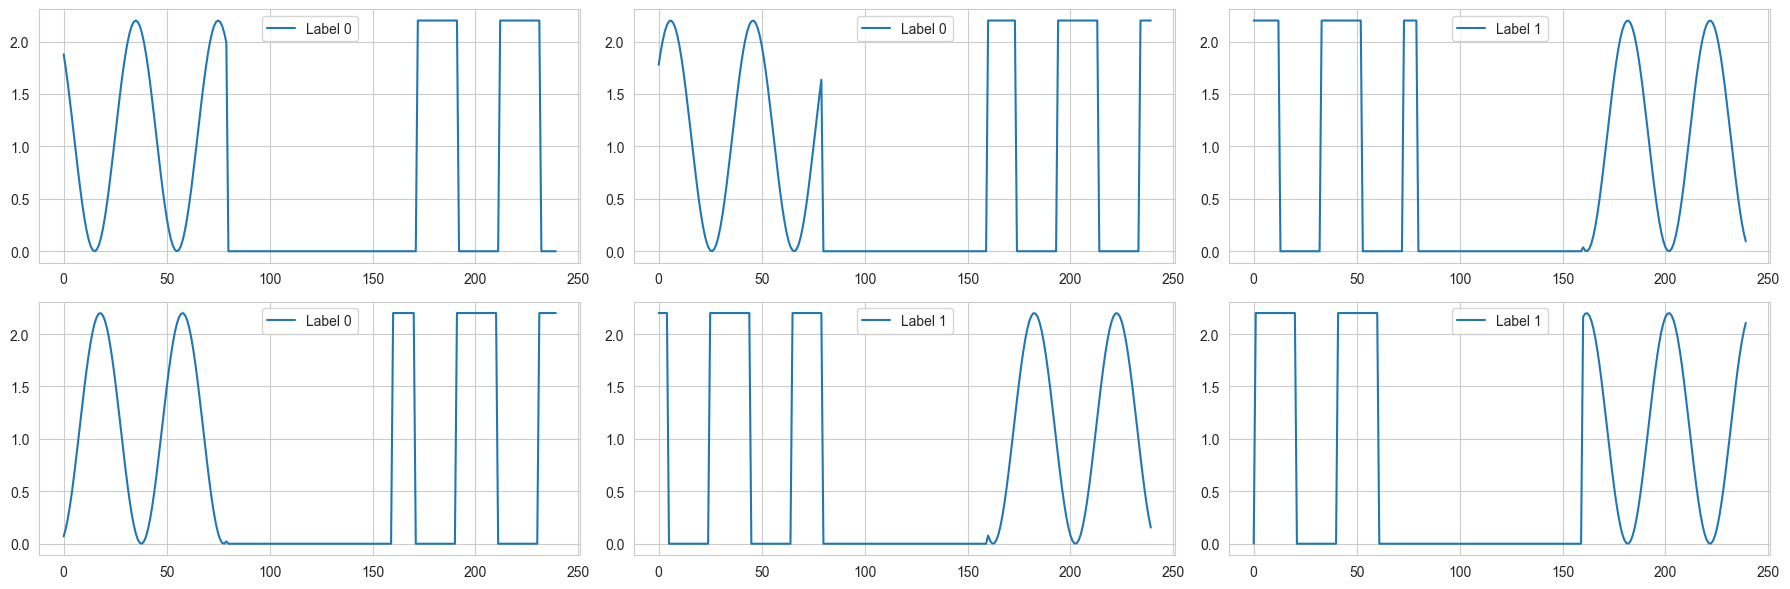

In [16]:
plot_wave(train_loader, save_path=os.path.join(unique_folder_name, 'wave_samples.png'))

In [17]:
plot_snn_spikes(model, test_loader, device, os.path.join(unique_folder_name, 'hidden_layer_spikes'), layer_name='Hidden', layer_size=hidden_size, num_steps=num_steps)

In [18]:
plot_snn_spikes(model, test_loader, device, os.path.join(unique_folder_name, 'output_layer_spikes'), layer_name='Output', layer_size=output_size, num_steps=num_steps)

In [19]:
plot_output_snn_spikes(model, test_loader, device, os.path.join(unique_folder_name, 'output_layer_spikes'), 'Output', 2, num_steps)

In [20]:
plot_spike_counts(hidden_spike_count, output_spike_count, output_spike_counts_neuron0, output_spike_counts_neuron1, num_epochs, os.path.join(unique_folder_name, 'spike_counts'))

### Membrane Potentials

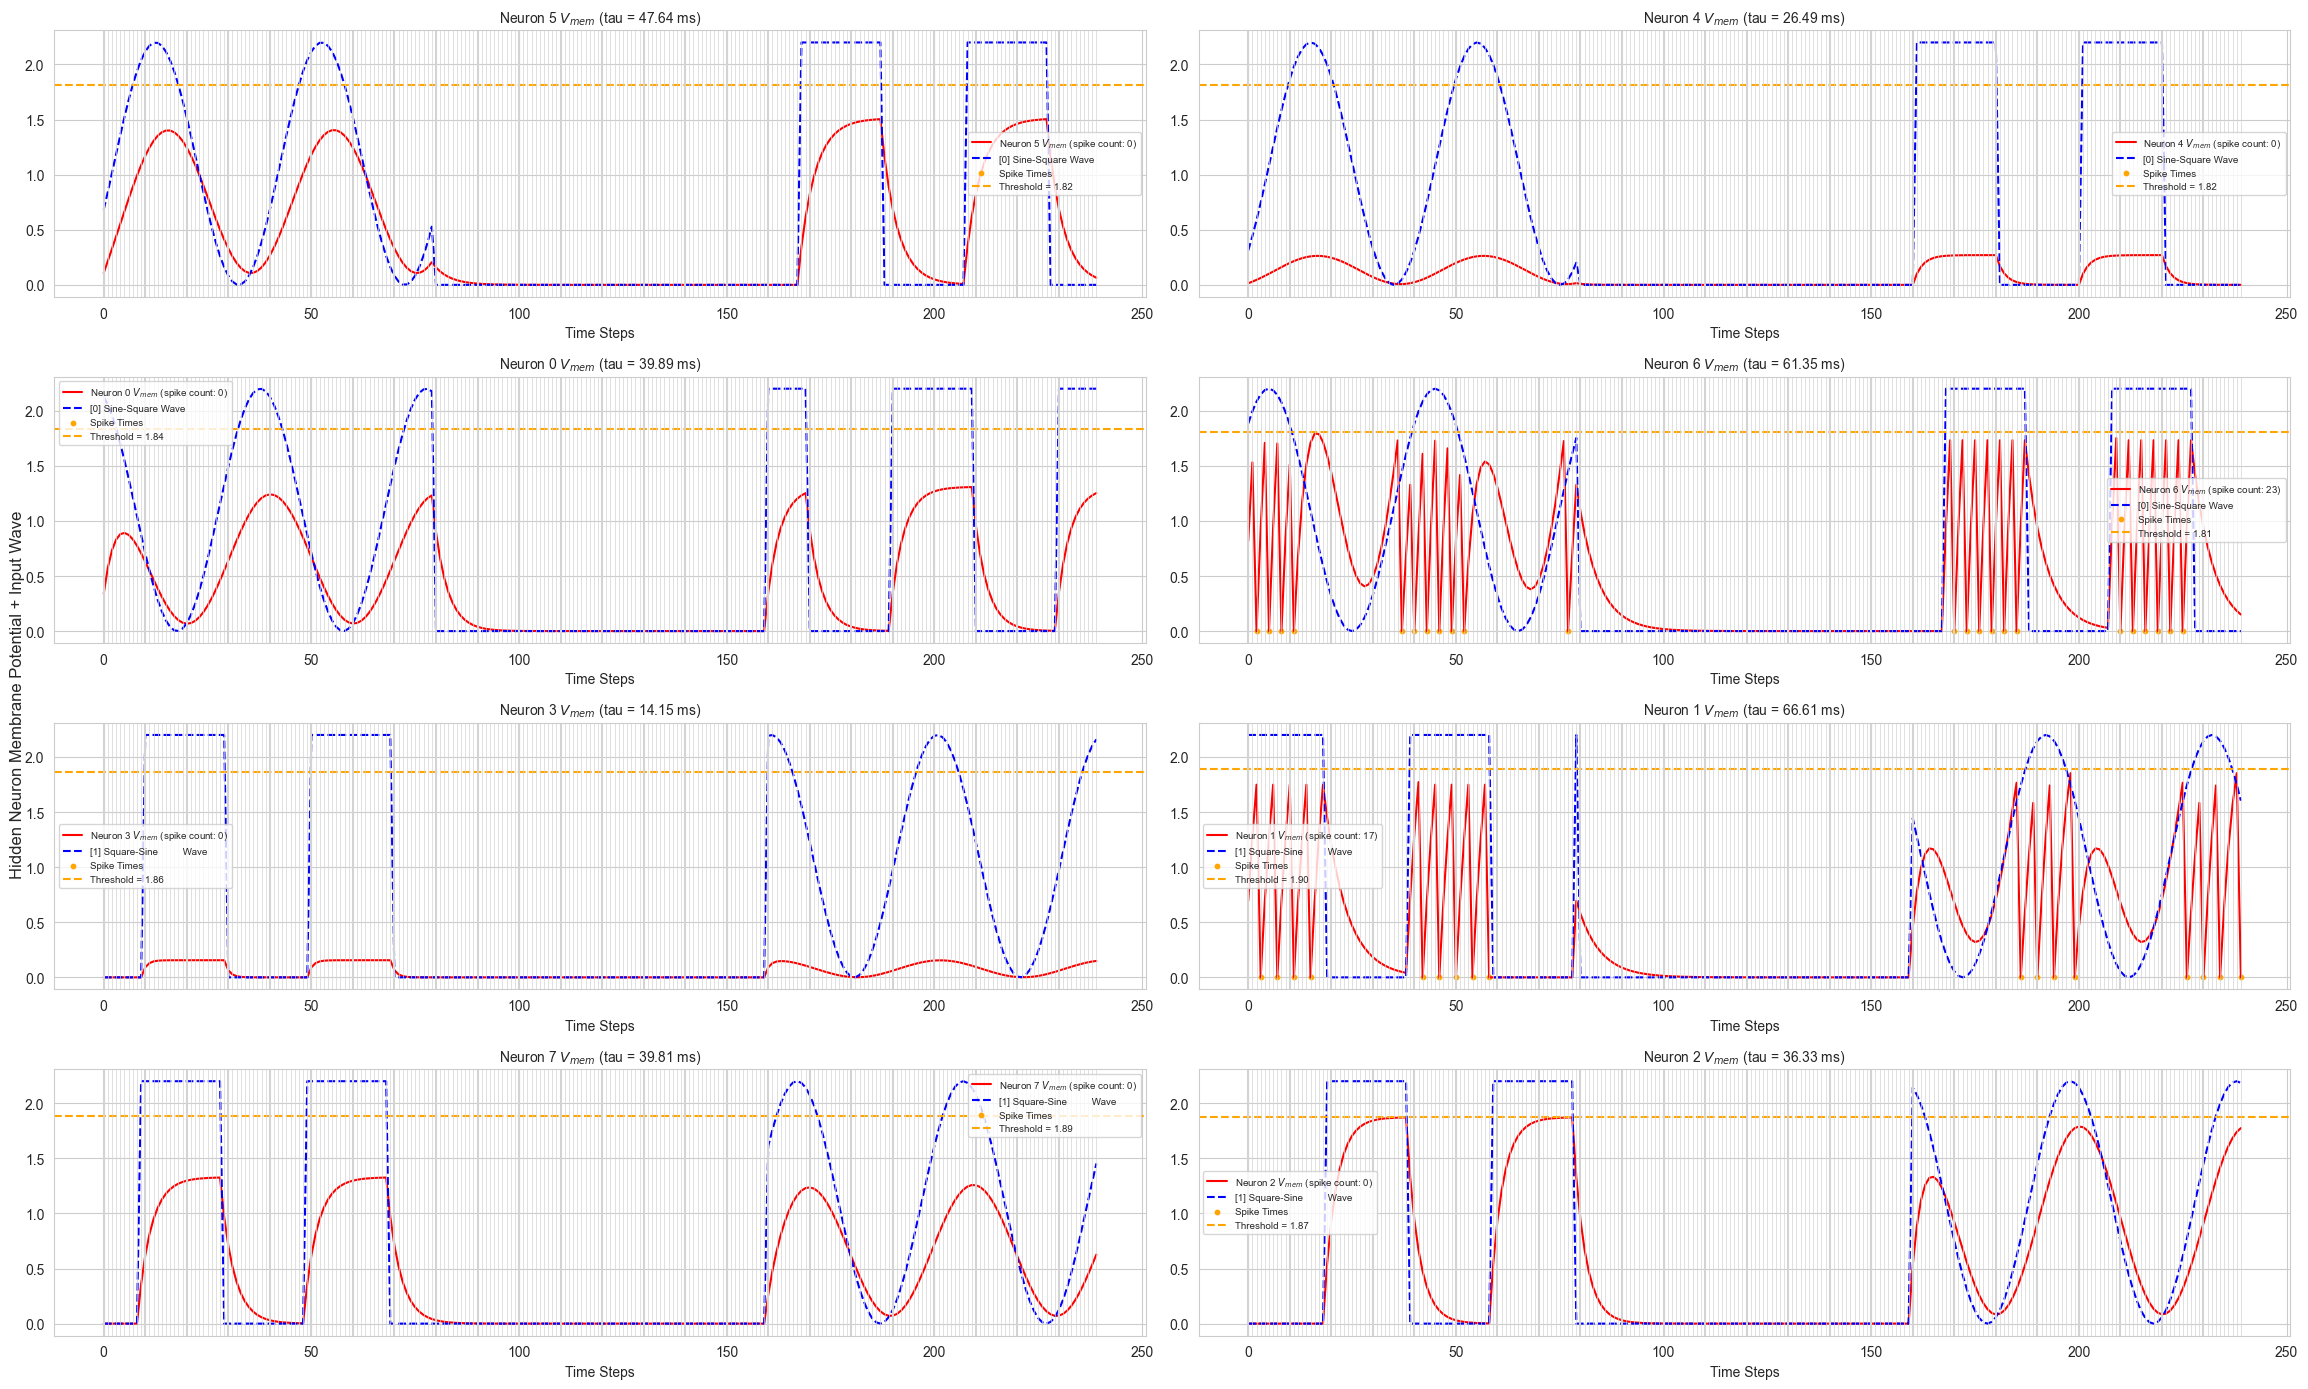

In [21]:
def plot_membrane_potentials1(model, test_loader, device, layer_name, layer_size, num_steps, deltaT, save_path):
    """
    Plots the membrane potentials of randomly selected neurons from a specified layer over time steps.

    Args:
    - model (torch.nn.Module): The trained spiking neural network model.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - device (str): Device to run the model on ('cpu' or 'cuda').
    - layer_name (str): Name of the layer to plot ('Hidden' or 'Output').
    - layer_size (int): Size of the layer.
    - num_steps (int): Number of time steps.
    - save_path (str): Path to save the plot.
    """
    num_neurons_to_plot = min(8, layer_size)
    neuron_indices = random.sample(range(layer_size), num_neurons_to_plot)
    waves, labels = next(iter(test_loader))
    waves = waves.to(device).float()
    labels = labels.to(device).long()
    spk1_rec, mem1_rec, spk2_rec, mem2_rec, hidden_spike_count, output_spike_count = model(waves)

    potentials = mem1_rec if layer_name == 'Hidden' else mem2_rec
    spikes = spk1_rec if layer_name == 'Hidden' else spk2_rec
    tau_values = -1000 * (deltaT / (np.log(model.lif1.beta.detach().cpu().numpy()) if layer_name == 'Hidden' else np.log(model.lif2.beta.detach().cpu().numpy())))
    thresholds = model.lif1.threshold.detach().cpu().numpy() if layer_name == 'Hidden' else model.lif2.threshold.detach().cpu().numpy()

    time_steps = np.arange(num_steps)
    fig, axs = plt.subplots((num_neurons_to_plot + 1) // 2, 2, figsize=(24, 8) if num_neurons_to_plot == 2 else (24, 14))
    axs = axs.flatten()

    sine_wave_indices = [i for i, label in enumerate(labels) if label == 0]
    square_wave_indices = [i for i, label in enumerate(labels) if label == 1]
    selected_indices = random.sample(sine_wave_indices, num_neurons_to_plot // 2) + random.sample(square_wave_indices, num_neurons_to_plot // 2)

    for i, neuron_idx in enumerate(neuron_indices):
        mem_potential = potentials[:, selected_indices[i], neuron_idx].detach().cpu().numpy()
        input_wave = waves[selected_indices[i]].cpu().numpy()
        neuron_spikes = spikes[:, selected_indices[i], neuron_idx].detach().cpu().numpy()
        spike_times = np.where(neuron_spikes == 1)[0]
        spike_count = len(spike_times)
        tau_value = tau_values[neuron_idx]
        threshold_value = thresholds[neuron_idx]

        axs[i].plot(time_steps, mem_potential, label=f'Neuron {neuron_idx} $V_{{mem}}$ (spike count: {spike_count})', color='red')
        axs[i].plot(time_steps, input_wave, label=f'{"[0] Sine-Square" if labels[selected_indices[i]] == 0 else "[1] Square-Sine        "} Wave', color='blue', linestyle='dashed')
        axs[i].scatter(spike_times, mem_potential[spike_times], color='orange', s=10, label='Spike Times')
        axs[i].axhline(y=threshold_value, color='orange', linestyle='--', label=f'Threshold = {threshold_value:.2f}')
        axs[i].set_xlabel('Time Steps', fontsize=10)
        axs[i].set_title(f'Neuron {neuron_idx} $V_{{mem}}$ (tau = {tau_value:.2f} ms)', fontsize=10)
        axs[i].grid(True)
        axs[i].legend(fontsize=7)

        # Add vertical lines
        for step in range(0, num_steps, 1):
            linewidth = 1.5 if step % 10 == 0 else 0.5
            axs[i].axvline(x=step, color='lightgrey', linewidth=linewidth)

    fig.text(0.04, 0.5, f'{layer_name} Neuron Membrane Potential + Input Wave', va='center', rotation='vertical', fontsize=12)
    plt.tight_layout(rect=[0.04, 0, 1, 1])
    plt.savefig(save_path + f"_{layer_name}_membrane_potentials.png", dpi=1200)


    plt.show()
    plt.close()

plot_membrane_potentials1(model, test_loader, device, 'Hidden', hidden_size, num_steps, deltaT, os.path.join(unique_folder_name, 'hidden_layer_membrane_potentials'))

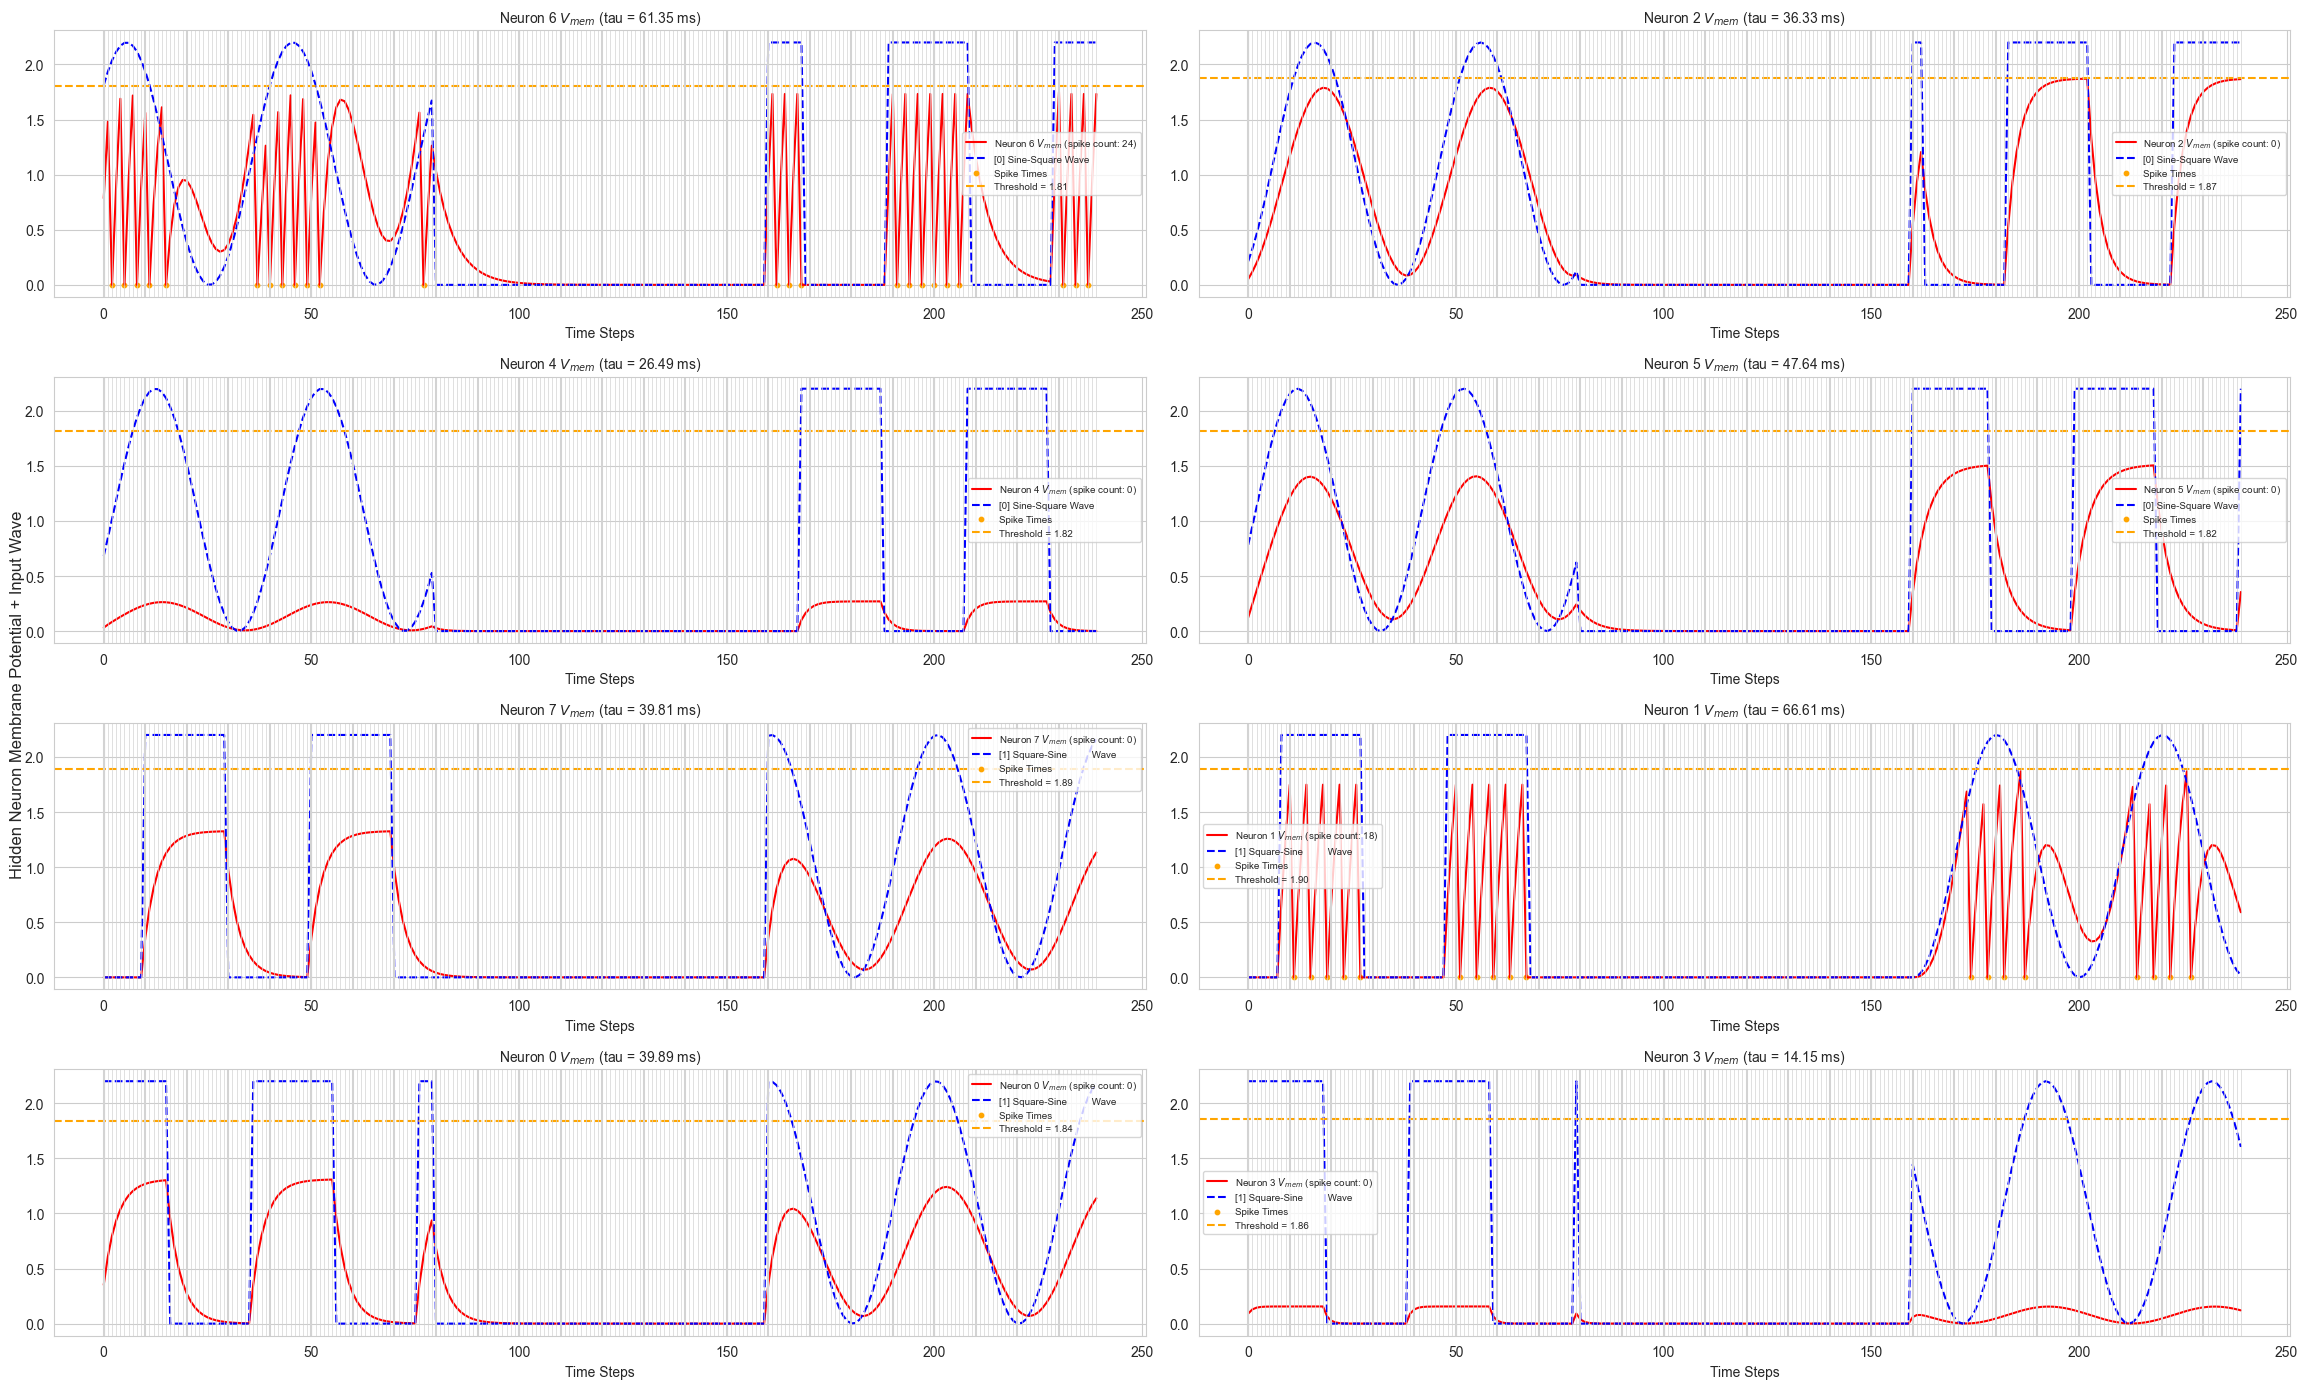

In [22]:
plot_membrane_potentials(model, test_loader, device, 'Hidden', hidden_size, num_steps, deltaT, os.path.join(unique_folder_name, 'hidden_membrane_potentials'))

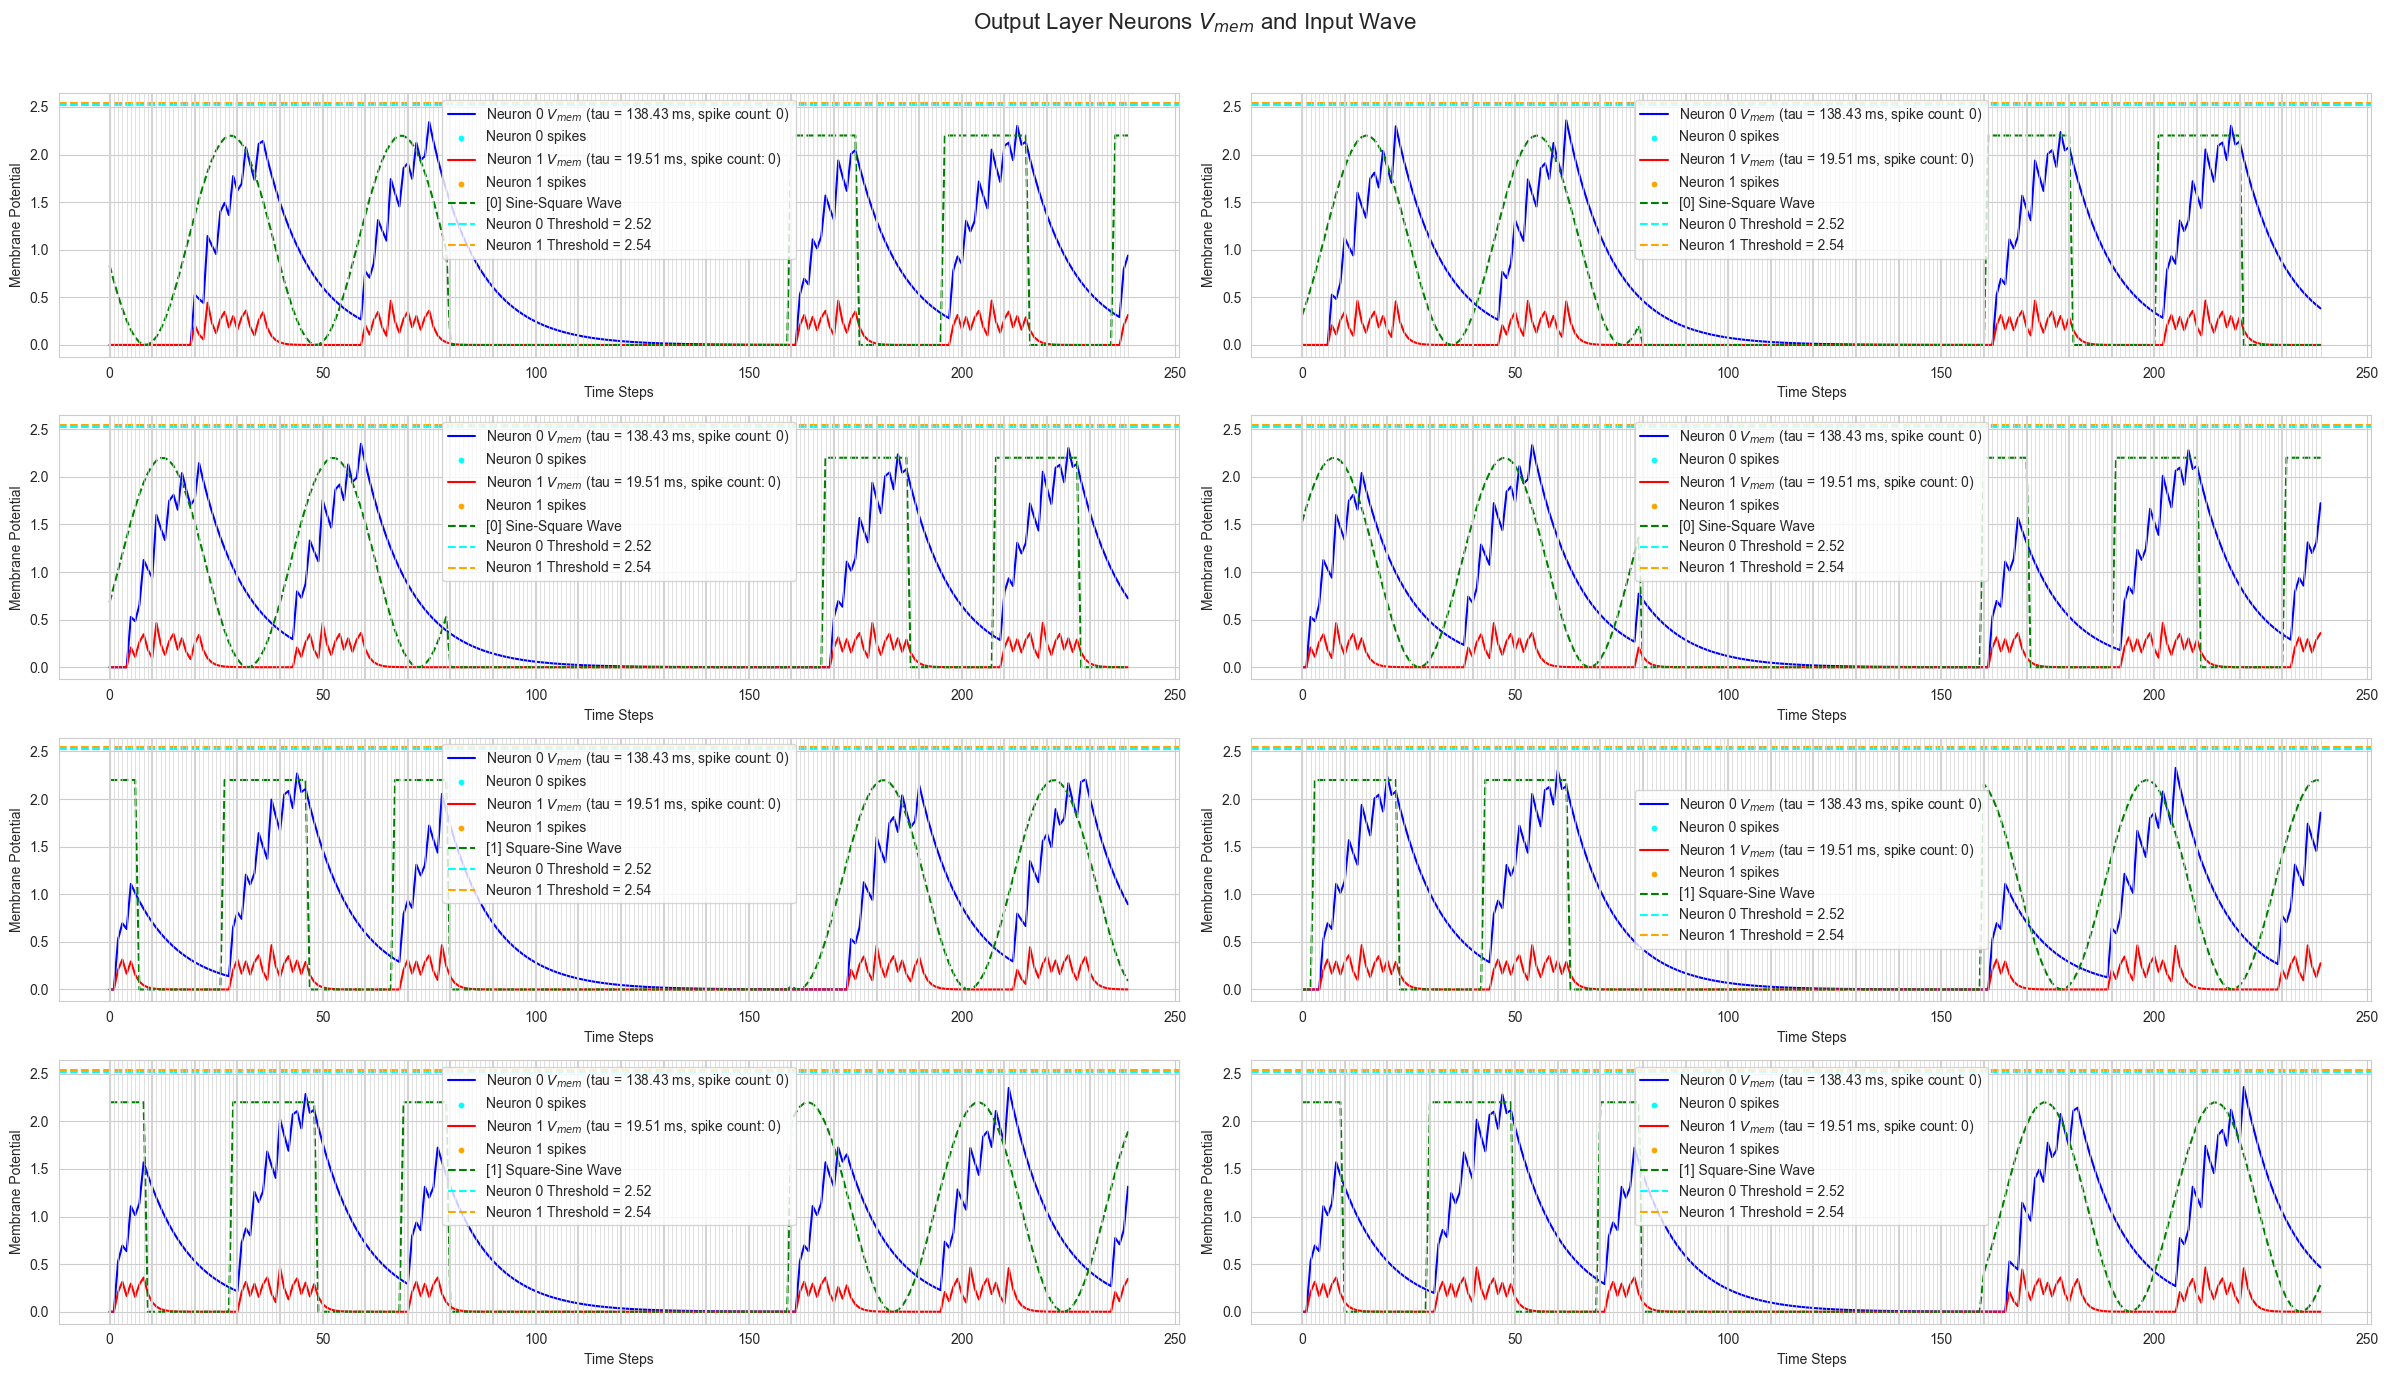

In [23]:
plot_output_membrane_potentials(model, test_loader, device, 'Output', 2, num_steps, deltaT, unique_folder_name)

### Threshold Potentials

In [24]:
plot_threshold_potentials(threshold_hidden_layer, num_epochs, os.path.join(unique_folder_name, 'threshold_hidden_layer'), 'Hidden')

In [25]:
plot_threshold_potentials(threshold_output_layer, num_epochs, os.path.join(unique_folder_name, 'threshold_output_layer'), 'Output')